In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
start = "2025-01-01"
end   = "2025-12-31"
dates = pd.date_range(start, end, freq="D")

rows = []

# Valori medi 
RENT = 320.00
BILLS = 40.00
UNI = 25.00
GROCERIES = 35.00
TRANSPORT = 2.50
EATING_OUT = 12.00
LEISURE = 8.00

for d in dates:
    # Mensili
    if d.day == 1:
        rows.append([d, RENT, "rent", "stanza", "bank"])
    if d.day == 10:
        rows.append([d, BILLS, "bills", "telefono", "card"])
    if d.day in [5, 20]:
        rows.append([d, UNI, "university", "materiale", "card"])

    # Settimanali 
    dow = d.dayofweek  # 0=lun ... 6=dom
    if dow in [1, 4]:  # mar, ven
        rows.append([d, GROCERIES, "groceries", "supermercato", "card"])
    if dow in [0, 2, 4]:  # lun, mer, ven
        rows.append([d, TRANSPORT, "transport", "bus", "card"])
    if dow == 5:  # sabato
        rows.append([d, EATING_OUT, "eating_out", "fuori", "card"])
    if dow == 6:  # domenica
        rows.append([d, LEISURE, "leisure", "bar/altro", "card"])

df = pd.DataFrame(rows, columns=["date", "amount", "category", "note", "payment_method"])
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.to_period("M")

print("Righe dataset:", len(df))
df.head()

Righe dataset: 413


,date,amount,category,note,payment_method,month
0,2025-01-01,320.0,rent,stanza,bank,2025-01
1,2025-01-01,2.5,transport,bus,card,2025-01
2,2025-01-03,35.0,groceries,supermercato,card,2025-01
3,2025-01-03,2.5,transport,bus,card,2025-01
4,2025-01-04,12.0,eating_out,fuori,card,2025-01


In [3]:
df.to_csv("data/expenses_12months_avg.csv", index=False)
print("Salvato: data/expenses_12months_avg.csv")

Salvato: data/expenses_12months_avg.csv


In [4]:
import os
print("CWD =", os.getcwd())
print("Contenuto cartella corrente =", os.listdir())

CWD = C:\Users\nunzi\Desktop\bari-student-cost-of-living
Contenuto cartella corrente = ['.git', '.gitignore', '.ipynb_checkpoints', '.venv', 'clean_project.ipynb', 'data', 'LICENSE', 'notebooks', 'README.md', 'results', 'src']


In [5]:
monthly_total = df.groupby("month")["amount"].sum()
category_total = df.groupby("category")["amount"].sum().sort_values(ascending=False)

print("Totale medio mensile:", round(monthly_total.mean(), 2))
print("\nTotale per categoria (anno):")
print(category_total.round(2))

Totale medio mensile: 832.71

Totale per categoria (anno):
category
rent          3840.0
groceries     3640.0
eating_out     624.0
university     600.0
bills          480.0
leisure        416.0
transport      392.5
Name: amount, dtype: float64


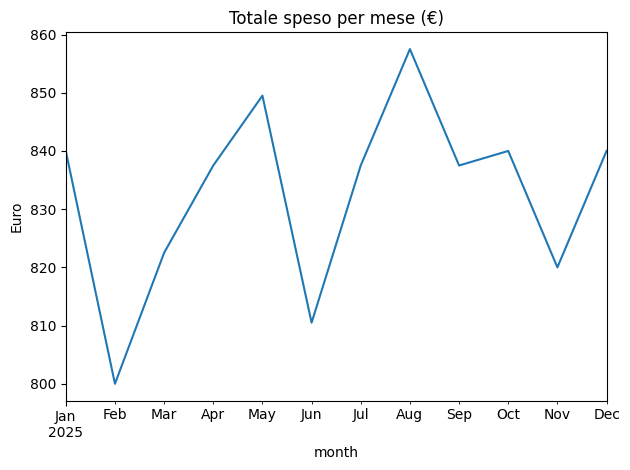

In [12]:
monthly_total.plot(title="Totale speso per mese (€)")
plt.ylabel("Euro")
plt.tight_layout()
plt.savefig("results/totale_mese.png")
plt.show()

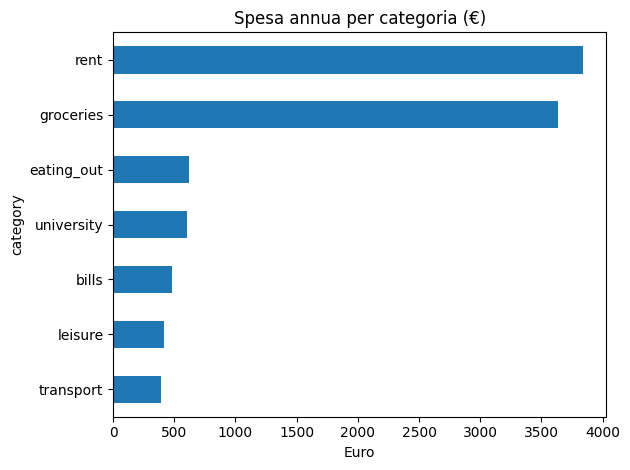

In [7]:
category_total.sort_values().plot(kind="barh", title="Spesa annua per categoria (€)")
plt.xlabel("Euro")
plt.tight_layout()
plt.savefig("results/category_breakdown.png")
plt.show()

In [8]:
rent_increase_pct = 0.35
budget = 1200

base_rent = 320.00
rent_after = base_rent * (1 + rent_increase_pct)

print(f"Affitto base: €{base_rent:.2f}")
print(f"Affitto dopo aumento +{rent_increase_pct*100:.0f}%: €{rent_after:.2f}")
print(f"Budget mensile: €{budget:.0f}")

Affitto base: €320.00
Affitto dopo aumento +35%: €432.00
Budget mensile: €1200


In [10]:
import numpy as np

# Parametri scenario
rent_increase_pct = 0.35
budget = 1200

base_rent = 320.00
rent_after = base_rent * (1 + rent_increase_pct)

print(f"Affitto base: €{base_rent:.2f}")
print(f"Affitto dopo aumento +{rent_increase_pct*100:.0f}%: €{rent_after:.2f}")
print(f"Budget mensile: €{budget:.0f}")

# Spesa giornaliera NON-affitto (sommata per giorno)
nonrent_daily = df[df["category"] != "rent"].groupby("date")["amount"].sum()

n_sim = 10000
days_in_month = 30

sim_nonrent = np.array([
    np.random.choice(nonrent_daily.values, size=days_in_month, replace=True).sum()
    for _ in range(n_sim)
])

sim_total_before = base_rent + sim_nonrent
sim_total_after  = rent_after + sim_nonrent

p_over_before = (sim_total_before > budget).mean()
p_over_after  = (sim_total_after  > budget).mean()

print(f"Probabilità sforamento PRIMA: {p_over_before*100:.1f}%")
print(f"Probabilità sforamento DOPO : {p_over_after*100:.1f}%")

print(f"Spesa simulata p50 prima: €{np.percentile(sim_total_before, 50):.0f}")
print(f"Spesa simulata p50 dopo : €{np.percentile(sim_total_after, 50):.0f}")

Affitto base: €320.00
Affitto dopo aumento +35%: €432.00
Budget mensile: €1200
Probabilità sforamento PRIMA: 0.1%
Probabilità sforamento DOPO : 2.3%
Spesa simulata p50 prima: €898
Spesa simulata p50 dopo : €1010


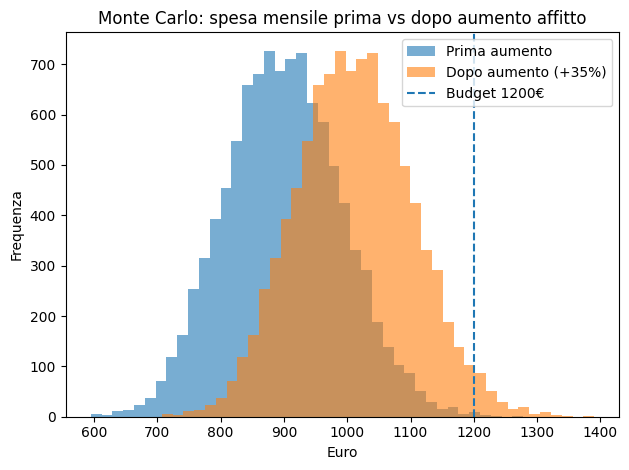

In [11]:
import matplotlib.pyplot as plt

plt.hist(sim_total_before, bins=40, alpha=0.6, label="Prima aumento")
plt.hist(sim_total_after,  bins=40, alpha=0.6, label="Dopo aumento (+35%)")
plt.axvline(budget, linestyle="--", label="Budget 1200€")

plt.title("Monte Carlo: spesa mensile prima vs dopo aumento affitto")
plt.xlabel("Euro")
plt.ylabel("Frequenza")
plt.legend()
plt.tight_layout()

plt.savefig("results/rent_increase_montecarlo.png")
plt.show()